<a href="https://colab.research.google.com/github/jtneumann/MLwork/blob/master/fastai/ml1/titanticTest4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q fastai==0.7.0
!pip install -q pandas==0.23.4

    100% |████████████████████████████████| 122kB 3.8MB/s 
    100% |████████████████████████████████| 1.5MB 13.5MB/s 
    100% |████████████████████████████████| 496.4MB 38kB/s 
    100% |████████████████████████████████| 3.6MB 4.4MB/s 
    100% |████████████████████████████████| 61kB 20.5MB/s 
    100% |████████████████████████████████| 12.4MB 2.5MB/s 
    100% |████████████████████████████████| 81kB 24.2MB/s 
mizani 0.5.3 has requirement pandas>=0.23.4, but you'll have pandas 0.22.0 which is incompatible.
plotnine 0.5.1 has requirement pandas>=0.23.4, but you'll have pandas 0.22.0 which is incompatible.
    100% |████████████████████████████████| 8.9MB 4.3MB/s 


In [0]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

from fastai.imports import *
from fastai.structured import *

from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display

from sklearn import metrics

In [0]:
import pandas as pd
df_raw = pd.read_csv('train.csv', low_memory=False)

In [0]:
train_cats(df_raw)

  ** proc_df** takes a data frame df and splits off the response variable, and
    changes the df into an entirely numeric dataframe. For each column of df 
    which is not in skip_flds nor in ignore_flds, na values are replaced by the
    median value of the column.
    Parameters:

In [0]:
df_trn, y_trn, nas = proc_df(df_raw, 'Survived')



In [0]:
set_rf_samples(800)

In [0]:
def split_vals(a,n): return a[:n], a[n:]
n_valid = 714
n_trn = len(df_trn)-n_valid
X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)
raw_train, raw_valid = split_vals(df_raw, n_trn)

In [0]:

def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [26]:
m=RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


CPU times: user 85.8 ms, sys: 11.2 ms, total: 97 ms
Wall time: 135 ms
[0.18411492357966466, 0.450645351127688, 0.9661016949152542, 0.7969187675070029, 0.6610169491525424]


In [27]:
%time preds = np.stack([t.predict(X_valid) for t in m.estimators_])
np.mean(preds[:,0]), np.std(preds[:,0])

CPU times: user 43.7 ms, sys: 1.95 ms, total: 45.7 ms
Wall time: 44.4 ms


(0.875, 0.33071891388307384)

In [28]:
def get_preds(t): return t.predict(X_valid)
%time preds = np.stack(parallel_trees(m, get_preds))
np.mean(preds[:,0]), np.std(preds[:,0])

CPU times: user 24.4 ms, sys: 45.1 ms, total: 69.5 ms
Wall time: 104 ms


(0.875, 0.33071891388307384)

Not Used

In [17]:
x = raw_valid.copy()
x['pred_std'] = np.std(preds, axis=0)
x['pred'] = np.mean(preds, axis=0)
x.Enclosure.value_counts().plot.barh();

AttributeError: ignored

In [29]:
fi = rf_feat_importance(m, df_trn); fi[:10]

,cols,imp
3,Sex,0.386800
7,Ticket,0.139741
2,Name,0.114146
0,PassengerId,0.091947
4,Age,0.070918
8,Fare,0.069745
1,Pclass,0.038756
9,Cabin,0.033503
5,SibSp,0.025168
11,Age_na,0.014348


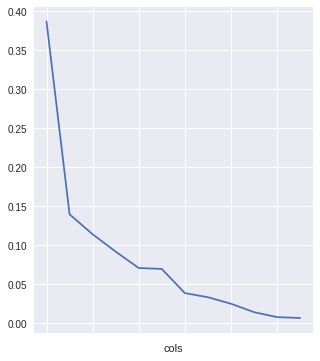

In [30]:
fi.plot('cols','imp',figsize=(5,6),legend=False)

In [0]:

def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

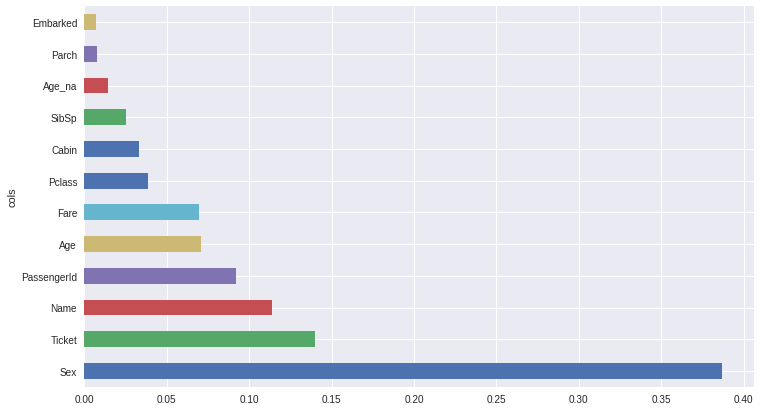

In [32]:
plot_fi(fi[:30]);

Final Model

In [33]:
to_keep = fi[fi.imp>0.025].cols; len(to_keep)

9

In [0]:
df_keep = df_trn[to_keep].copy()
X_train, X_valid = split_vals(df_keep, n_trn)

In [35]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5,
                          n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


[0.17894639623101288, 0.4025218572098421, 0.8559018427417001, 0.3228082579205366, -0.35618527904838415]


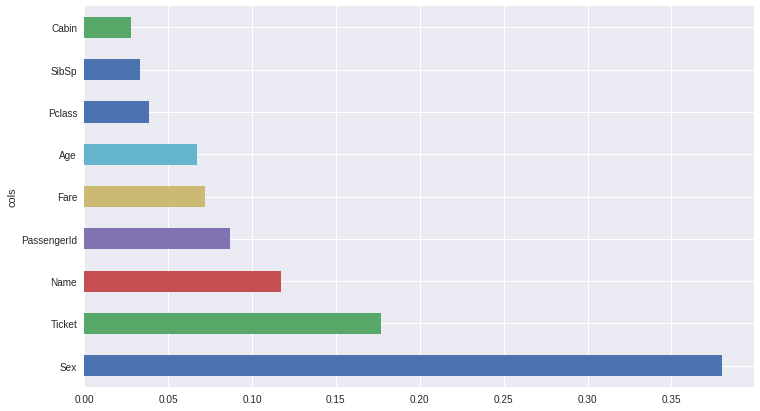

In [36]:
fi = rf_feat_importance(m, df_keep)
plot_fi(fi);

In [37]:
df_trn2, y_trn, nas = proc_df(df_raw, 'Survived', max_n_cat=7)
X_train, X_valid = split_vals(df_trn2, n_trn)

m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


[0.1788769132815515, 0.40673467852762846, 0.8560137245268893, 0.30855900901414157, -0.5438232751257803]


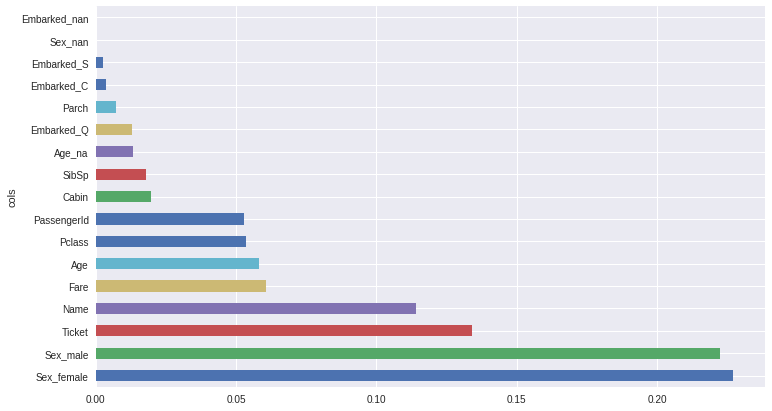

In [38]:
fi = rf_feat_importance(m, df_trn2)
plot_fi(fi[:25]);

Removing Redundant Features

In [0]:
from scipy.cluster import hierarchy as hc

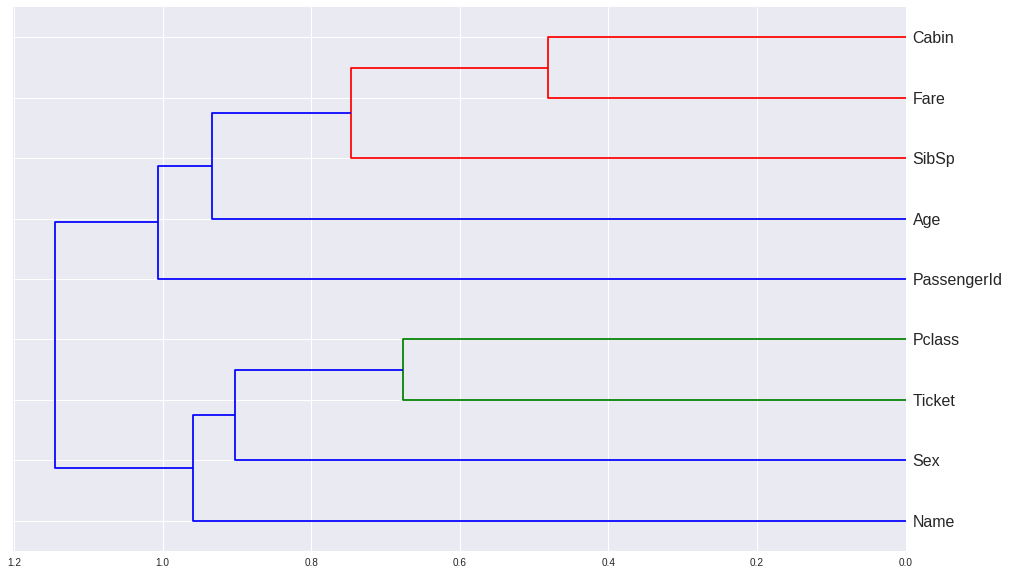

In [40]:
corr = np.round(scipy.stats.spearmanr(df_keep).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=df_keep.columns, orientation='left', leaf_font_size=16)
plt.show()

In [0]:

def get_oob(df):
    m = RandomForestRegressor(n_estimators=30, min_samples_leaf=5, max_features=0.6, n_jobs=-1, oob_score=True)
    x, _ = split_vals(df, n_trn)
    m.fit(x, y_train)
    return m.oob_score_

In [42]:
get_oob(df_keep)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


-0.11726522344652635

Extrapolation

In [43]:
df_ext = df_keep.copy()
df_ext['is_valid'] = 1
df_ext.is_valid[:n_trn] = 0
x, y, nas = proc_df(df_ext, 'is_valid')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [44]:
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(x, y);
m.oob_score_

0.9988776655443322

In [45]:
fi = rf_feat_importance(m, x); fi[:10]

,cols,imp
3,PassengerId,0.968914
4,Age,0.008014
1,Ticket,0.007368
2,Name,0.006541
5,Fare,0.004645
8,SibSp,0.002443
7,Cabin,0.001635
6,Pclass,0.000442
0,Sex,0.000000


In [0]:
feats=['PassengerId', 'Ticket', 'Age']

In [47]:

(X_train[feats]/1000).describe()

,PassengerId,Ticket,Age
count,177.00000,177.000000,177.000000
mean,0.08900,0.362373,0.027926
std,0.05124,0.195083,0.013500
min,0.00100,0.003000,0.000830
25%,0.04500,0.197000,0.021000
50%,0.08900,0.356000,0.028000
75%,0.13300,0.542000,0.033000
max,0.17700,0.679000,0.071000


In [0]:
x.drop(feats, axis=1, inplace=True)

In [49]:
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(x, y);
m.oob_score_

0.7822671156004489

In [50]:
fi = rf_feat_importance(m, x); fi[:10]

,cols,imp
1,Name,0.460366
2,Fare,0.327730
5,SibSp,0.066964
4,Cabin,0.064752
0,Sex,0.040773
3,Pclass,0.039416


In [0]:
set_rf_samples(500)

In [0]:
feats=['PassengerId', 'Ticket', 'Age','Name','Fare']

In [53]:
X_train, X_valid = split_vals(df_keep, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


[0.19153965221427888, 0.39365599931594536, 0.8349065273333489, 0.3523110812446243, 0.11456177611538754]


In [54]:

for f in feats:
    df_subs = df_keep.drop(f, axis=1)
    X_train, X_valid = split_vals(df_subs, n_trn)
    m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
    m.fit(X_train, y_train)
    print(f)
    print_score(m)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


PassengerId
[0.19067774315335853, 0.3966327058030375, 0.8363889921967383, 0.3424787951532713, 0.2083496337365376]
Ticket


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


[0.1907247749422124, 0.39592516473270173, 0.8363082710045909, 0.344822567118652, 0.05717157653266436]
Age


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


[0.19473067985464315, 0.41040363000881974, 0.8293598304550683, 0.2960284554369469, 0.09467539515762236]
Name


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


[0.19377194920295576, 0.3959034414911214, 0.8310359426593921, 0.34489446043825134, 0.11353831104515211]
Fare


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


[0.1906525043959747, 0.3980158282756735, 0.8364323015539428, 0.337885033669295, 0.07272320066759796]


In [0]:
reset_rf_samples()


In [56]:
df_subs = df_keep.drop(['PassengerId', 'Name', 'Fare'], axis=1)
X_train, X_valid = split_vals(df_subs, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.27803755335938785, 0.39562590652288104, 0.652128035148665, 0.34581261849645295, 0.3456905369474288]


In [62]:

m = RandomForestRegressor(n_estimators=820, max_features=0.5, n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 955 ms, sys: 129 ms, total: 1.08 s
Wall time: 943 ms
[0.14884973776753996, 0.39585718859855146, 0.9002969000494057, 0.3450475217809027, 0.264007116704122]


In [66]:
X_train.head()

,Sex,Ticket,Age,Pclass,Cabin,SibSp
0,2,524,22.0,3,0,1
1,1,597,38.0,1,82,1
2,1,670,26.0,3,0,0
3,1,50,35.0,1,56,1
4,2,473,35.0,3,0,0


In [63]:
!ls

sample_data  test.csv  train.csv


In [64]:
df_test=pd.read_csv('./test.csv')
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [0]:
df_test.drop(['PassengerId','Embarked','Name','Fare','Parch'], axis=1, inplace=True)

In [0]:
train_cats(df_test)

In [0]:
df_test, _, nas = proc_df(df_test)

In [72]:
df_test.head()


,Pclass,Sex,Age,SibSp,Ticket,Cabin,Age_na
0,3,2,34.5,0,153,0,False
1,3,1,47.0,1,222,0,False
2,2,2,62.0,0,74,0,False
3,3,2,27.0,0,148,0,False
4,3,1,22.0,1,139,0,False


In [0]:
df_test.drop(['Age_na'], axis=1, inplace=True)

In [0]:
survived = m.predict(df_test)

In [76]:
survived

array([0.40488, 0.09512, 0.15488, 0.52073, 0.43171, 0.50854, 0.51463, 0.59756, 0.4939 , 0.41341, 0.52073,
       0.88902, 0.84878, 0.15732, 0.84634, 0.48415, 0.20244, 0.48659, 0.52073, 0.14878, 0.89634, 0.53049,
       0.88171, 0.91463, 0.84878, 0.09634, 0.7122 , 0.48537, 0.76829, 0.59878, 0.09634, 0.46951, 0.42439,
       0.52073, 0.8939 , 0.50488, 0.52073, 0.42073, 0.4878 , 0.41707, 0.14634, 0.67561, 0.12317, 0.50366,
       0.79146, 0.4878 , 0.84634, 0.52073, 0.8378 , 0.16829, 0.82195, 0.52073, 0.41829, 0.77195, 0.52073,
       0.50244, 0.27317, 0.35732, 0.52073, 0.8939 , 0.43415, 0.5061 , 0.42683, 0.43171, 0.78902, 0.52073,
       0.42683, 0.87927, 0.91707, 0.86829, 0.48415, 0.42805, 0.51463, 0.9    , 0.80976, 0.80732, 0.52073,
       0.77805, 0.61829, 0.48415, 0.60122, 0.85122, 0.92073, 0.52073, 0.61951, 0.60366, 0.52073, 0.42683,
       0.52073, 0.53537, 0.43171, 0.52073, 0.84024, 0.52073, 0.87927, 0.4878 , 0.86341, 0.51341, 0.42683,
       0.42439, 0.82927, 0.44634, 0.52073, 0.4

In [0]:
survived.shape

(418,)

In [0]:
df_test.shape

(418, 12)

In [0]:
df_test['Survived'] = survived

In [0]:
df_test

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_na,Survived
0,892,3,207,2,34.5,0,0,153,7.8292,0,2,False,0
1,893,3,404,1,47.0,1,0,222,7.0000,0,3,False,1
2,894,2,270,2,62.0,0,0,74,9.6875,0,2,False,1
3,895,3,409,2,27.0,0,0,148,8.6625,0,3,False,1
4,896,3,179,1,22.0,1,1,139,12.2875,0,3,False,1
5,897,3,367,2,14.0,0,0,262,9.2250,0,3,False,0
6,898,3,85,1,30.0,0,0,159,7.6292,0,2,False,1
7,899,2,58,2,26.0,1,1,85,29.0000,0,3,False,0
8,900,3,5,1,18.0,0,0,101,7.2292,0,1,False,1
9,901,3,104,2,21.0,2,0,270,24.1500,0,3,False,0


In [0]:
df_test.drop(['Pclass','Name','Sex','Age','SibSp','Parch','Ticket','Fare','Cabin','Embarked','Age_na'], axis=1, inplace=True)

In [0]:
df_test.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,1
3,895,1
4,896,1


In [0]:
df_test.to_csv('test1.csv', index=False)